In [15]:
import pandas as pd
import numpy as np

# EDA

In [41]:
df_sintatic = pd.read_pickle("data/sintetic_wemb_MiniLM_L6_v2.pkl")

In [42]:
df_sintatic.columns

Index(['Sentence', 'Expansion', 'Acronym', 'Sentence_Emb', 'Expansion_Emb'], dtype='object')

In [43]:
df_sintatic["Acronym"].unique()

array(['AR', 'AI', 'ATS', 'CTA', 'CAD ', 'CA', 'CP', 'CPM', 'CRM', 'DEI',
       'ER', 'EVP', 'MBO', 'MA', 'PM', 'PR', 'RPO', 'RA', 'ROI', 'SME',
       'SSA', 'WFN ', 'DD', 'MSG', 'MM', 'YOLO '], dtype=object)

In [44]:
df_sintatic.head(10)

,Sentence,Expansion,Acronym,Sentence_Emb,Expansion_Emb
600,Managing AR is crucial for maintaining a healt...,Accounts Receivable,AR,"[[-0.043010436, 0.030251851, -0.4291916, -0.00...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
603,Effective AR management reduces the risk of ba...,Accounts Receivable,AR,"[[-0.07896995, 0.22533315, -0.024554426, -0.20...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
604,Timely follow-ups with customers can speed up ...,Accounts Receivable,AR,"[[-0.14787723, -0.34664398, -0.7436014, -0.067...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
605,AR software automates invoice generation and p...,Accounts Receivable,AR,"[[-0.3722177, -0.23643449, -0.63709235, -0.106...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
606,Accurate AR records are essential for financia...,Accounts Receivable,AR,"[[-0.34439862, -0.46760595, -0.5512057, 0.2068...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
607,The AR team works closely with sales to resolv...,Accounts Receivable,AR,"[[-0.48167038, -0.44413516, -0.16403441, -0.24...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
608,Maintaining a low AR balance improves liquidity.,Accounts Receivable,AR,"[[-0.22960667, 0.3557909, 0.2159821, 0.3814340...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
609,Late payments can negatively impact a companys...,Accounts Receivable,AR,"[[0.014309144, -0.12479106, 0.2125512, -0.2527...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
610,AR specialists reconcile payments with outstan...,Accounts Receivable,AR,"[[-0.7684152, 0.1342151, -0.10955137, -0.11971...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
611,Businesses offer discounts for early AR settle...,Accounts Receivable,AR,"[[0.14325157, -0.09320769, -0.15272455, 0.1174...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."


In [57]:
def return_ambiguos(df):
    unique_acronyms = df.groupby('Acronym')['Expansion'].nunique()
    ambiguous_acronyms = unique_acronyms[unique_acronyms > 1].index
    ambigous_df = df[df['Acronym'].isin(ambiguous_acronyms)]
    ambigous_df = ambigous_df.sort_values(by='Expansion')
    return ambigous_df

In [62]:
def return_not_ambiguous(df):
    unique_acronyms = df.groupby('Acronym')['Expansion'].nunique()
    not_ambiguous_acronyms = unique_acronyms[unique_acronyms == 1].index
    not_ambiguous_df = df[df['Acronym'].isin(not_ambiguous_acronyms)]
    not_ambiguous_df = not_ambiguous_df.sort_values(by='Expansion')
    return not_ambiguous_df


In [63]:
return_not_ambiguous(df_sintatic)

,Sentence,Expansion,Acronym,Sentence_Emb,Expansion_Emb


In [69]:
df_sintatic

,Sentence,Expansion,Acronym,Sentence_Emb,Expansion_Emb
600,Managing AR is crucial for maintaining a healt...,Accounts Receivable,AR,"[[-0.043010436, 0.030251851, -0.4291916, -0.00...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
603,Effective AR management reduces the risk of ba...,Accounts Receivable,AR,"[[-0.07896995, 0.22533315, -0.024554426, -0.20...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
604,Timely follow-ups with customers can speed up ...,Accounts Receivable,AR,"[[-0.14787723, -0.34664398, -0.7436014, -0.067...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
605,AR software automates invoice generation and p...,Accounts Receivable,AR,"[[-0.3722177, -0.23643449, -0.63709235, -0.106...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
606,Accurate AR records are essential for financia...,Accounts Receivable,AR,"[[-0.34439862, -0.46760595, -0.5512057, 0.2068...","[[-0.79373854, -0.5333496, -0.42829642, -0.297..."
...,...,...,...,...,...
11596,YOLO's real-time object detection is used in i...,you only look once,YOLO,"[[-0.59974045, -0.27605793, -0.11152144, -0.19...","[[0.190255, 0.02182666, 0.42293993, 0.01516081..."
11597,The YOLO framework is constantly evolving to m...,you only look once,YOLO,"[[-0.31038028, 0.055248577, -0.08950778, -0.22...","[[0.190255, 0.02182666, 0.42293993, 0.01516081..."
11576,The YOLO algorithm is instrumental in scene un...,you only look once,YOLO,"[[-0.14091569, 0.009884621, 0.2010719, -0.5174...","[[0.190255, 0.02182666, 0.42293993, 0.01516081..."
11588,YOLO's real-time capabilities are vital in aug...,you only look once,YOLO,"[[-0.24682483, -0.18698072, -0.0111497715, -0....","[[0.190255, 0.02182666, 0.42293993, 0.01516081..."


# Disambiguation 

In [24]:
from disambiguation import embedding_based_only, jaccard_based

results_embedding = {
    "True": [],
    "Label": [],
    "Prediction": []
}

results_embedding = embedding_based_only(df_sintatic, results_embedding)
results_df = pd.DataFrame(results_embedding)

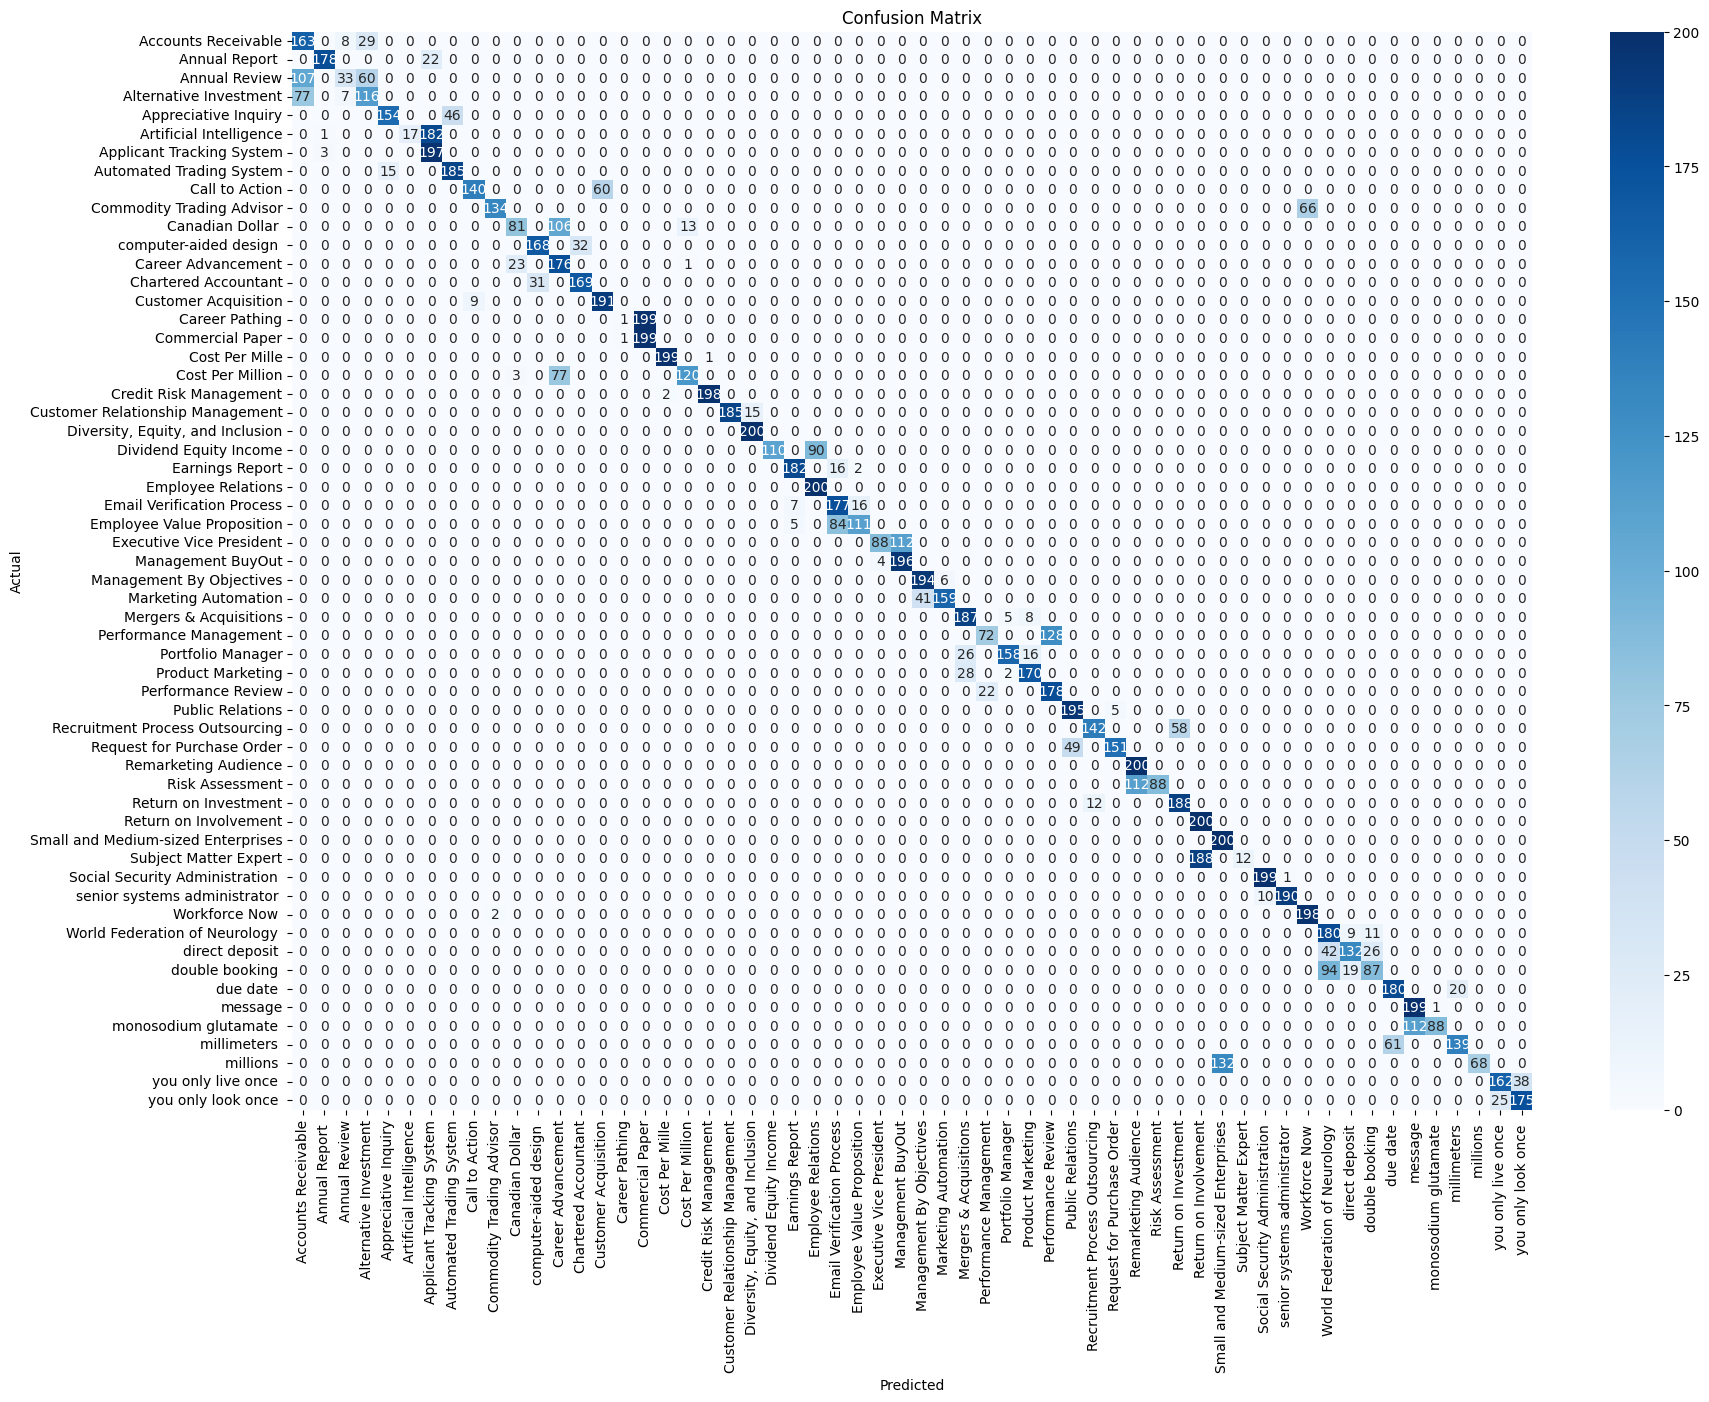

In [20]:
from sklearn.metrics import confusion_matrix, precision_score
from utils import plot_cfm

confusion = confusion_matrix(results_df['Label'], results_df['Prediction'])
plot_cfm(confusion, results_df)

In [21]:
results_df["True"].sum() / len(results_df)

0.7550862068965517

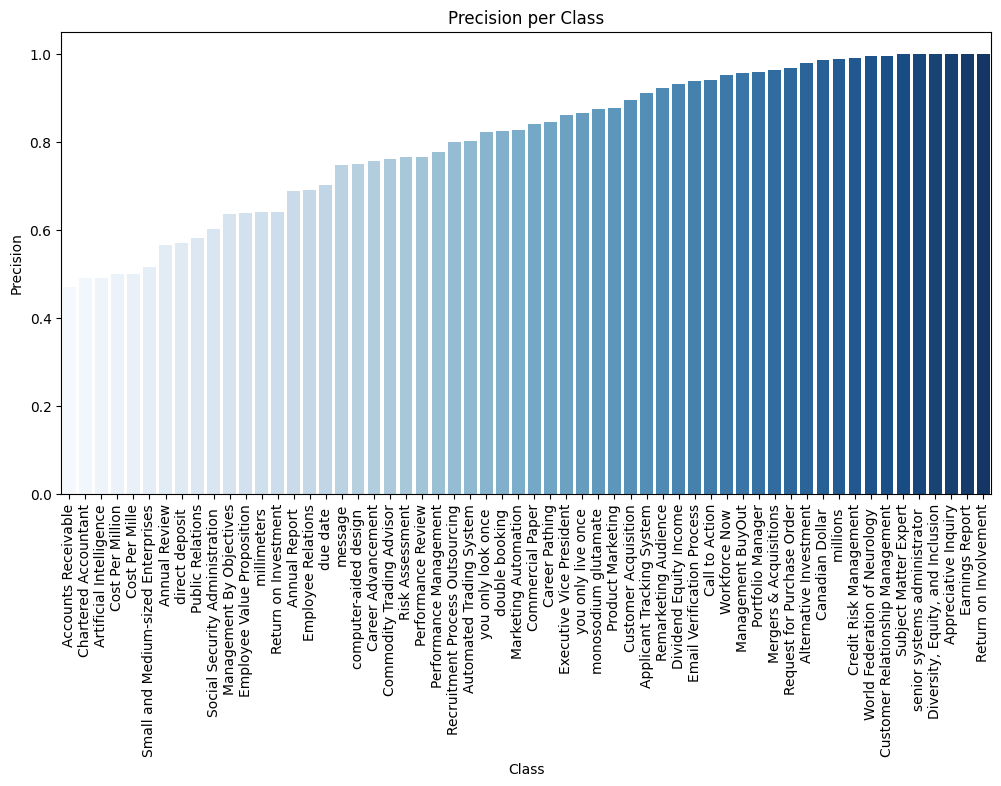

In [22]:
import matplotlib.pyplot as plt
from utils import plot_bar
from sklearn.metrics import precision_score

class_labels = results_df['Label'].unique()
precisions = []

for label in class_labels:
    true_labels = results_df['Label'] == label
    predicted_labels = results_df['Prediction'] == label
    precision = precision_score(true_labels, predicted_labels)
    precisions.append(precision)

precision_df = pd.DataFrame({'Class': class_labels, 'Precision': precisions})
precision_df = precision_df.sort_values(by='Precision', ascending=True)
plot_bar(precision_df)

In [23]:
def calculate_precisions(results_df):
    unique_labels = results_df["Label"].unique()
    precisions = []
    for label in unique_labels:
        true_labels = results_df['Label'] == label
        predicted_labels = results_df['Prediction'] == label
        precision = precision_score(true_labels, predicted_labels)
        precisions.append(precision)
    return unique_labels, precisions

def filter_low_precision_classes(results_df, precisions, threshold=0.70):
    low_precision_classes = [label for label, precision in zip(unique_labels, precisions) if precision >= threshold]
    return results_df[~results_df['Label'].isin(low_precision_classes)]

unique_labels, precisions = calculate_precisions(results_df)
filtered_results_df = filter_low_precision_classes(results_df, precisions, threshold=0.60)

for i, acc_l in enumerate(filtered_results_df["Label"].unique()):
    precision = precisions[list(unique_labels).index(acc_l)]
    print(f"{i+1}. {acc_l}, {precision:.2f}")

1. Accounts Receivable, 0.47
2. Annual Review, 0.57
3. Artificial Intelligence, 0.49
4. Chartered Accountant, 0.49
5. Cost Per Mille, 0.50
6. Cost Per Million, 0.50
7. Public Relations, 0.58
8. Small and Medium-sized Enterprises, 0.52
9. direct deposit , 0.57
